## Building Models

### Imports and Defaults

In [190]:
import pandas                as pd
import numpy                 as np
import tensorflow            as tf
import lightgbm              as lgbm
import seaborn               as sns
import matplotlib.pyplot     as plt
import statsmodels.api       as sm
import tensorflow            as tf
import math

from statsmodels.formula.api import logit

from sklearn                 import metrics
from sklearn.metrics         import plot_confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble        import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing   import StandardScaler
from sklearn.utils           import resample 
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors       import KNeighborsClassifier

from tensorflow              import keras
from tensorflow.keras        import layers

from pylab                   import rcParams

from keras.models            import Sequential
from keras.layers            import Dense

from   datetime              import datetime
from   datetime              import timedelta

import os 

%matplotlib inline
rcParams['figure.figsize']  = 15, 10
rcParams['axes.titlesize']  = 20
rcParams['axes.labelsize']  = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size']       = 18

import warnings
warnings.filterwarnings("ignore")

### Functions

In [164]:
def roundTime(dt=datetime.now(), roundTo=60):
   
   seconds  = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo

   return dt + timedelta(0,rounding-seconds,-dt.microsecond)

In [183]:
def saveTextFile(path, text):
    textFile = open(path, "w")
    textFile.write(text)
    textFile.close()

In [210]:
def create_downsample(training_df, features, target_variable, ratio_of_majority_to_minority, repl=False):

    df = training_df[[target_variable] + features]
    
    negative = df[df[target_variable]==0]
    positive = df[df[target_variable]==1]

    negative_downsampled = resample(negative,
                                replace = repl, # sample without replacement
                                n_samples = len(positive)*ratio_of_majority_to_minority, 
                                random_state = 0, stratify=negative['Document']) 

    downsampled = pd.concat([negative_downsampled, positive])
    
    print(downsampled[target_variable].value_counts())
                      
    return downsampled

In [236]:
def cross_validation_with_downsample(training_df, splits, features, target_variable, ratio_of_majority_to_minority, model):
    state = 9999
    df = training_df[[target_variable]+features]
    y = np.array(df[target_variable])
    X = np.array(df[features])
    
    skf = StratifiedKFold(n_splits=splits, 
               shuffle=True, random_state=state
              )
    
    
    precision = []
    recall = []
    f1 = []
    support = []
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        

        df2 = pd.DataFrame(X_train, columns=features)
        df2[target_variable] = y_train
            
        negative = df2[df2[target_variable]==0]
        positive = df2[df2[target_variable]==1]

        try:
            negative_downsampled = resample(negative,
                                    replace = False, # sample without replacement
                                    n_samples = len(positive)*ratio_of_majority_to_minority, 
                                    random_state=state) 
        except:
            negative_downsampled = resample(negative,
                                    replace = True, # sample without replacement
                                    n_samples = len(positive)*ratio_of_majority_to_minority, 
                                    random_state=state) 
            
        downsampled = pd.concat([negative_downsampled, positive])
        
        y_train = np.array(downsampled[target_variable])
        X_train = np.array(downsampled[features])
    
        if model == 'lgbm':
            clf = lgbm.LGBMClassifier(random_state=state)
        elif model == 'RandomForest':
            clf = RandomForestClassifier(random_state=state)
        elif model == 'ExtraTrees':
            clf = ExtraTreesClassifier(random_state=state)
            
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        metric_array = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')[0:3]
        precision.append(metric_array[0])
        recall.append(metric_array[1])
        f1.append(metric_array[2])
    
    stats = {'Precision': precision, 'Recall':recall,'F1':f1,}
    
    cross_val_df = pd.DataFrame(stats)
    cross_val_df.index.name='Fold'
    cross_val_df = cross_val_df.transpose()
    cross_val_df['Cross-Val Mean'] = cross_val_df.apply(np.mean, axis = 1)

    return cross_val_df

In [237]:
def cross_validation_no_downsample(training_df, splits, features, target_variable, model):
    state = 9999
    df = training_df[[target_variable]+features]
    y = np.array(df[target_variable])
    X = np.array(df[features])
    
    skf = StratifiedKFold(n_splits=splits, 
               shuffle=True, random_state=state
              )
    skf.get_n_splits(X, y) 
    
    precision = []
    recall = []
    f1 = []
    support = []
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        if model == 'lgbm':
            clf = lgbm.LGBMClassifier(random_state=state)
        elif model == 'RandomForest':
            clf = RandomForestClassifier(random_state=state)
        elif model == 'ExtraTrees':
            clf = ExtraTreesClassifier(random_state=state)
            
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        
        
        metric_array = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')[0:3]
        precision.append(metric_array[0])
        recall.append(metric_array[1])
        f1.append(metric_array[2])
    
    stats = {'Precision': precision, 'Recall':recall,'F1':f1,}
    
    cross_val_df = pd.DataFrame(stats)
    cross_val_df.index.name='Fold'
    cross_val_df = cross_val_df.transpose()
    cross_val_df['Cross-Val Mean'] = cross_val_df.apply(np.mean, axis = 1)

    return cross_val_df

## Pretraining heatmap and data processing

Set directory


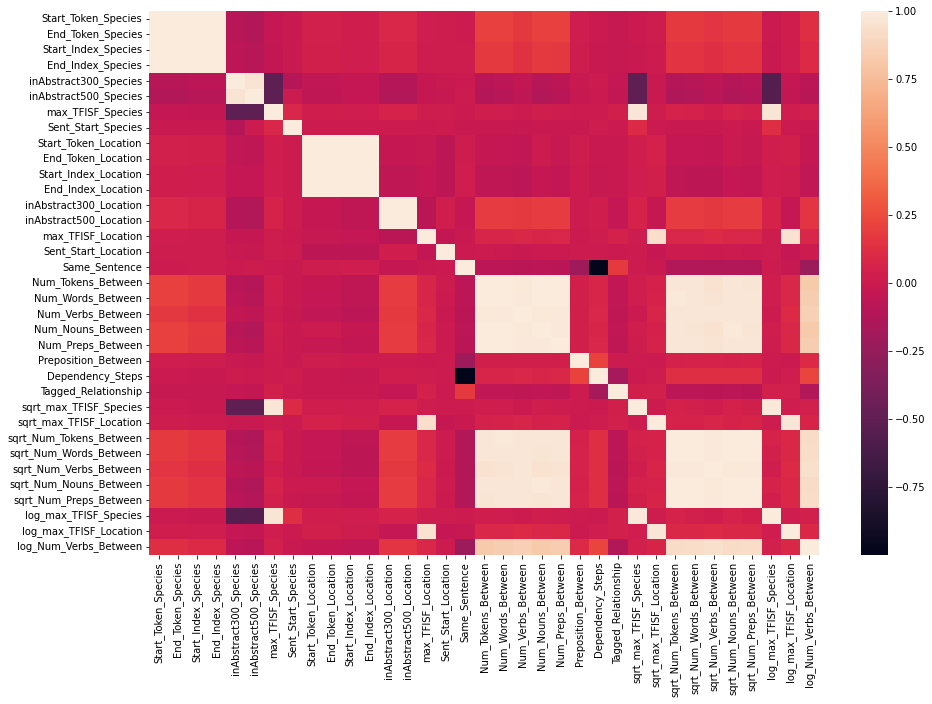

In [279]:
# Load data
relations                  = pd.read_csv('Metrics\\DataSet\\workingDataset.csv', index_col=0, dtype={'Tagged_Relationship': 'int8'})
col_to_downcast            = [col for col in relations.columns if relations[col].dtype==int]
relations[col_to_downcast] = relations[col_to_downcast].apply(pd.to_numeric, downcast='integer')

cols            = list(relations.columns)
cols.remove('Tagged_Relationship')
cols.append('Tagged_Relationship')
relations       = relations[cols]

# Directory information
print('Set directory')
date      = datetime.now()
day, time = str(roundTime(date, 10*60)).split(' ')
rootDir   = 'Results\\' + day 
rootDir   = rootDir + '\\' + next(os.walk(rootDir))[1][-1]

# Set specific folders
featuresFolder  = rootDir + '\\Features'
confusionFolder = rootDir + '\\ConfusionMatrices'
metricsFolder   = rootDir + '\\IndividualMetrics'
resultsFolder   = rootDir + '\\Results'
graphsFolder    = rootDir + '\\Graphs'
GISFolder    = rootDir + '\\GISPaper'

# Create the directories
for folder in [featuresFolder,confusionFolder,metricsFolder,resultsFolder,graphsFolder]:
    if not os.path.exists(folder):
        os.makedirs(folder)
        
# Heatmap of features
corr = relations.corr()
heatmap = sns.heatmap(corr)
heatmap.figure.savefig(featuresFolder + '\\HeatMap.png')

# Pre training data manipulation
features_all = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'max_TFISF_Species',
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location',
                'max_TFISF_Location', 
                'Sent_Start_Location', 
                'Same_Sentence',
                'Num_Tokens_Between', 
                'Num_Words_Between', 
                'Num_Verbs_Between',
                'Num_Nouns_Between',
                'Num_Preps_Between', 
                'Preposition_Between',
                'Dependency_Steps',
                'sqrt_max_TFISF_Species', 
                'sqrt_max_TFISF_Location',
                'sqrt_Num_Tokens_Between', 
                'sqrt_Num_Words_Between',
                'sqrt_Num_Verbs_Between', 
                'sqrt_Num_Nouns_Between',
                'sqrt_Num_Preps_Between', 
                'log_max_TFISF_Species',
                'log_max_TFISF_Location', 
                'log_Num_Verbs_Between']

features_all = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'max_TFISF_Species',
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location',
                'max_TFISF_Location', 
                'Sent_Start_Location', 
                'Same_Sentence',
                'Num_Tokens_Between', 
                'Num_Words_Between', 
                'Num_Verbs_Between',
                'Num_Nouns_Between',
                'Num_Preps_Between', 
                'Preposition_Between',
                'Dependency_Steps']

features_cat = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location', 
                'Sent_Start_Location', 
                'Same_Sentence', 
                'Preposition_Between']

features_raw = features_all[:16]

y = relations.Tagged_Relationship

X = relations[features_all]

sqrt_max_TFISF_Species               = [math.sqrt(x) for x in relations['max_TFISF_Species']]
relations['sqrt_max_TFISF_Species']  = sqrt_max_TFISF_Species

sqrt_max_TFISF_Location              = [math.sqrt(x) for x in relations['max_TFISF_Location']]
relations['sqrt_max_TFISF_Location'] = sqrt_max_TFISF_Location

sqrt_Num_Tokens_Between              = [math.sqrt(x) for x in relations['Num_Tokens_Between']]
relations['sqrt_Num_Tokens_Between'] = sqrt_Num_Tokens_Between

sqrt_Num_Words_Between               = [math.sqrt(x) for x in relations['Num_Words_Between']]
relations['sqrt_Num_Words_Between']  = sqrt_Num_Words_Between

sqrt_Num_Verbs_Between               = [math.sqrt(x) for x in relations['Num_Verbs_Between']]
relations['sqrt_Num_Verbs_Between']  = sqrt_Num_Verbs_Between

sqrt_Num_Nouns_Between               = [math.sqrt(x) for x in relations['Num_Nouns_Between']]
relations['sqrt_Num_Nouns_Between']  = sqrt_Num_Nouns_Between

sqrt_Num_Preps_Between               = [math.sqrt(x) for x in relations['Num_Preps_Between']]
relations['sqrt_Num_Preps_Between']  = sqrt_Num_Preps_Between

log_max_TFISF_Species                = [math.log(x) if x > 0 else 0 for x in relations['max_TFISF_Species']]
relations['log_max_TFISF_Species']   = log_max_TFISF_Species

log_max_TFISF_Location               = [math.log(x) if x > 0 else 0 for x in relations['max_TFISF_Location']]
relations['log_max_TFISF_Location']  = log_max_TFISF_Location

log_Num_Verbs_Between                = [math.log(x) if x > 0 else 0 for x in relations['Num_Verbs_Between']]
relations['log_Num_Verbs_Between']   = log_Num_Verbs_Between

x = relations[features_all + ['Document', 'Tagged_Relationship']]

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    x['Tagged_Relationship'], 
                                                    test_size    = 0.3,
                                                    random_state = 0, 
                                                    shuffle      = True,
                                                    stratify     = x[['Document', 'Tagged_Relationship']])
train                = x_train.copy()
x_train.drop(columns = ['Document', 'Tagged_Relationship'], inplace=True)
x_test_with_document = x_test.copy()
x_test.drop(columns  = ['Document', 'Tagged_Relationship'], inplace=True)

## Models

### Adaboost

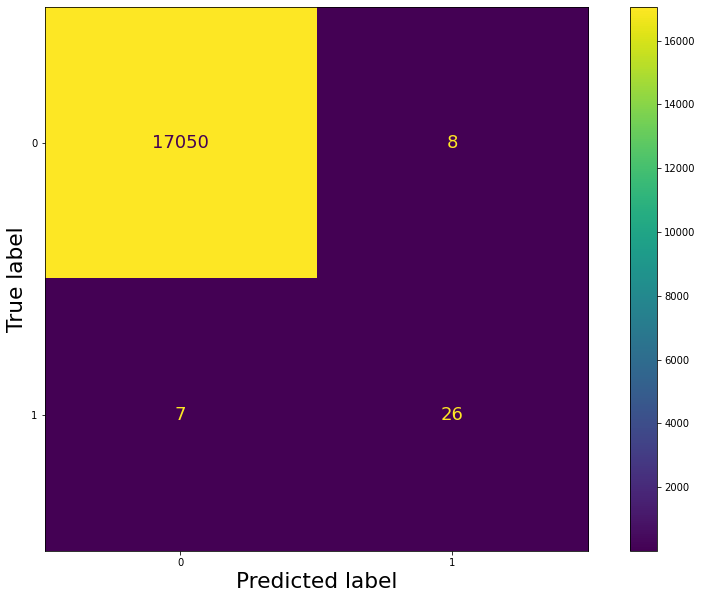

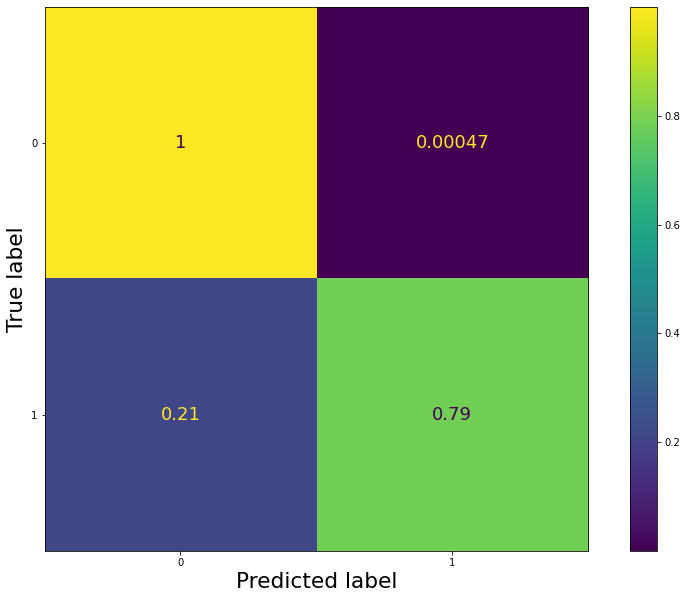

In [194]:
adaboost_clf    = AdaBoostClassifier(random_state=0)
adaboost_clf.fit(x_train[features_raw], y_train)
y_pred_adaboost = adaboost_clf.predict(x_test[features_raw])

# Metrics
saveTextFile(metricsFolder + '\\AdaBoost.txt', metrics.classification_report(y_test, y_pred_adaboost))

# First confusion Matrix
confusionMatrix = plot_confusion_matrix(adaboost_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\AdaBoost01.png')

# Second confusion matrix
confusionMatrix = plot_confusion_matrix(adaboost_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\AdaBoost02.png')

# Feature importance table
pd.DataFrame(sorted(list(zip(features_raw, adaboost_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns = ['Feature', 'Importance'])

# Top features list
top_abst_features    = list(pd.DataFrame(sorted(list(zip(features_all, adaboost_clf.feature_importances_)), 
                            key     = lambda x:x[1], 
                            reverse = True), 
                            columns = ['Feature', 'Importance'])['Feature'][:10])

### Light Gradient Boosting Machine (LGBM)

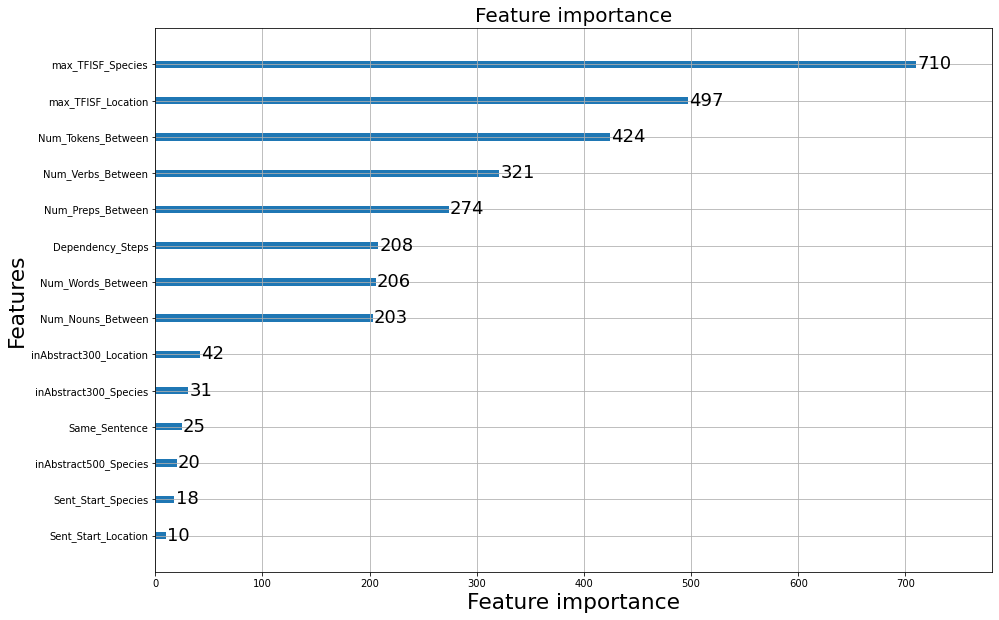

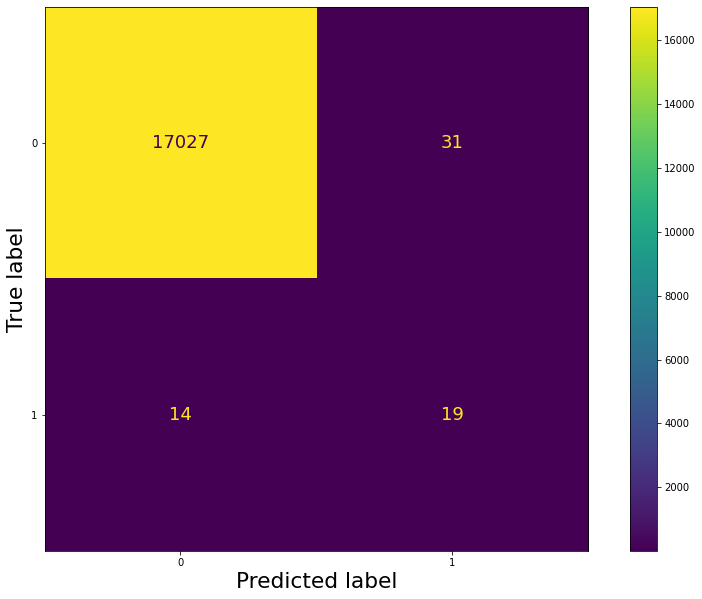

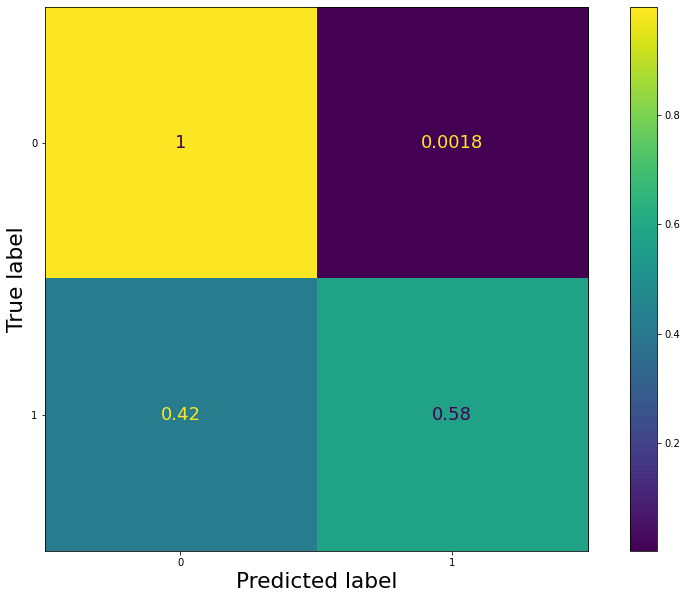

In [198]:
lgbm_clf = lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)

# Feature importance image
lgbm.plot_importance(lgbm_clf)

# Feature importance table
lgbm_feat_imp = pd.DataFrame(sorted(list(zip(features_raw, lgbm_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])
lgbm_feat_imp['Normalised']= lgbm_feat_imp.Importance / lgbm_feat_imp.Importance.sum() 
lgbm_feat_imp

# Top feature importance printout
top_lgbm_features = list(pd.DataFrame(sorted(list(zip(features_raw, lgbm_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:14])
top_lgbm_features

# LGBM Metrics
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
saveTextFile(metricsFolder + '\\LGBM.txt', metrics.classification_report(y_test, y_pred_lgbm))

# Confusion matrix 
confusionMatrix = plot_confusion_matrix(lgbm_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\LGBM01.png')

# Second confusion matrix
confusionMatrix = plot_confusion_matrix(lgbm_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\LGBM02.png')

### Random Forest Classifier

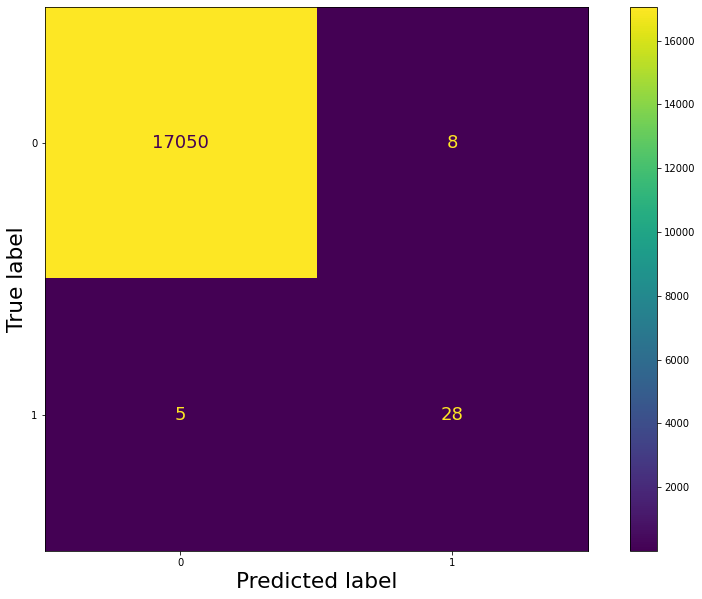

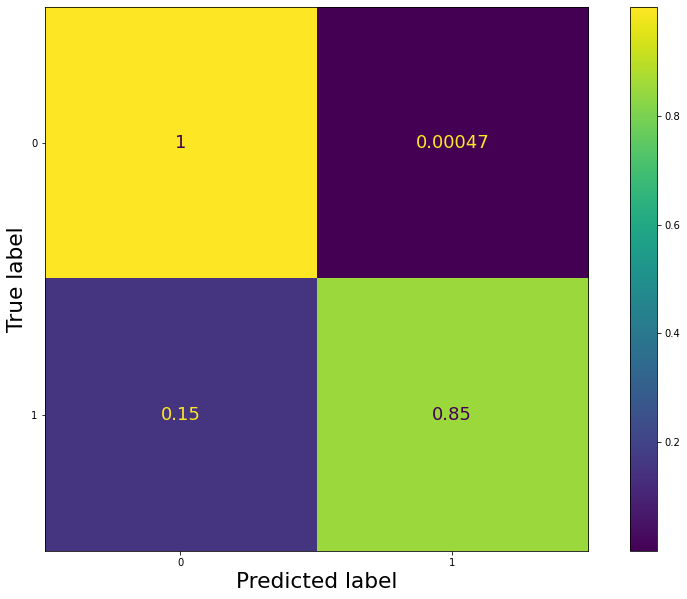

In [201]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)

# Geature importance table
pd.DataFrame(sorted(list(zip(features_raw, rf_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])

# Top features list
top_rf_features = list(pd.DataFrame(sorted(list(zip(features_raw, rf_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:10])

# Metrics
y_pred_rf = rf_clf.predict(x_test[features_raw])
saveTextFile(metricsFolder + '\\RandomForest.txt', metrics.classification_report(y_test, y_pred_rf))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(rf_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\RandomForest01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(rf_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\RandomForest02.png')

### Extra Randomised Trees

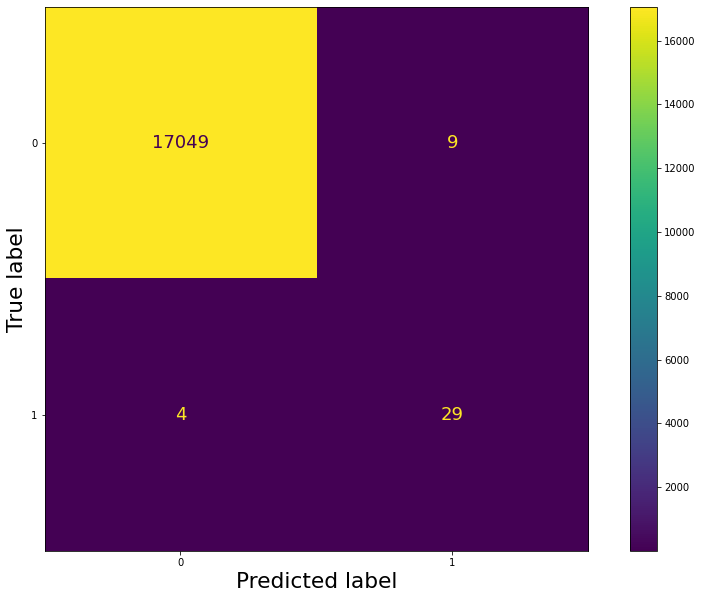

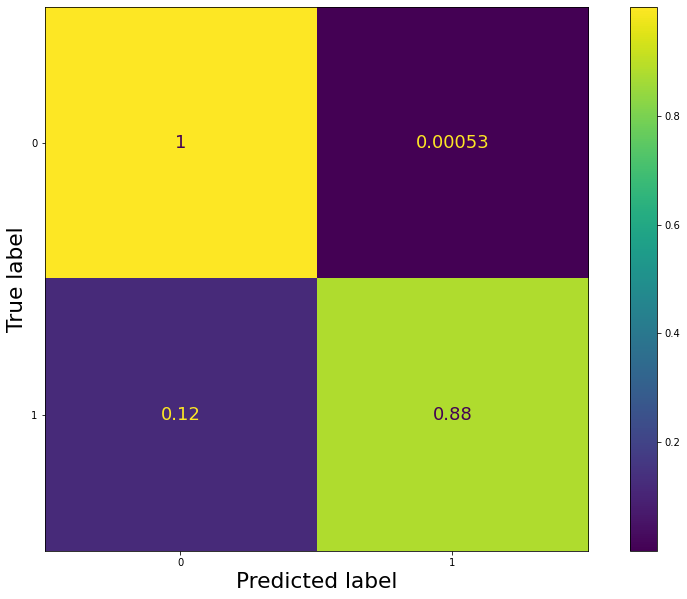

In [202]:
xt_clf = ExtraTreesClassifier(random_state=0)
xt_clf.fit(x_train[features_raw], y_train)

# Feature Importance table
pd.DataFrame(sorted(list(zip(features_raw, xt_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])

# Top features list
top_et_features = list(pd.DataFrame(sorted(list(zip(features_raw, xt_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:10])

# Metrics
y_pred_xt = xt_clf.predict(x_test[features_raw])
saveTextFile(metricsFolder + '\\ExtraRandomizedTrees.txt', metrics.classification_report(y_test, y_pred_xt))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(xt_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\ExtraRandomizedTrees01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(xt_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\ExtraRandomizedTrees02.png')

### Logistic Regression

Optimization terminated successfully.
         Current function value: 0.007466
         Iterations 27
                            Logit Regression Results                           
Dep. Variable:     Tagged_Relationship   No. Observations:                39879
Model:                           Logit   Df Residuals:                    39869
Method:                            MLE   Df Model:                            9
Date:                 Mon, 24 Jan 2022   Pseudo R-squ.:                  0.4725
Time:                         11:09:44   Log-Likelihood:                -297.74
converged:                        True   LL-Null:                       -564.40
Covariance Type:             nonrobust   LLR p-value:                4.176e-109
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -211.5781    141.035     -1.500      0.134    -488.001      

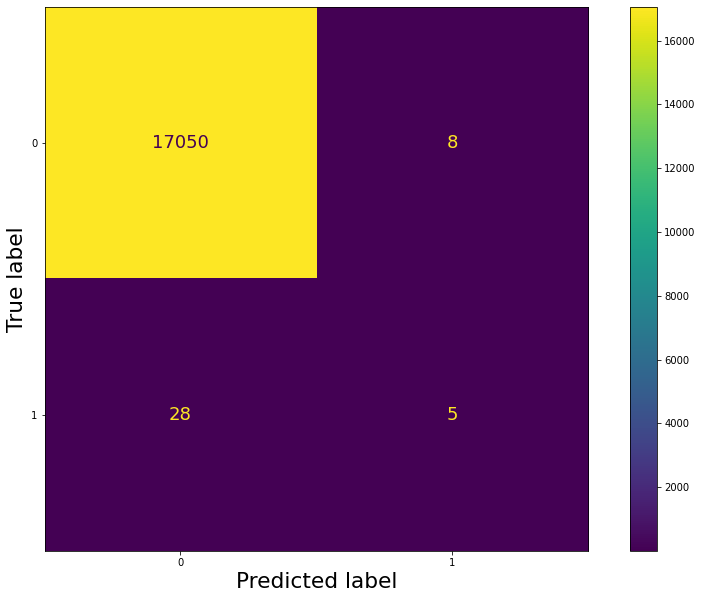

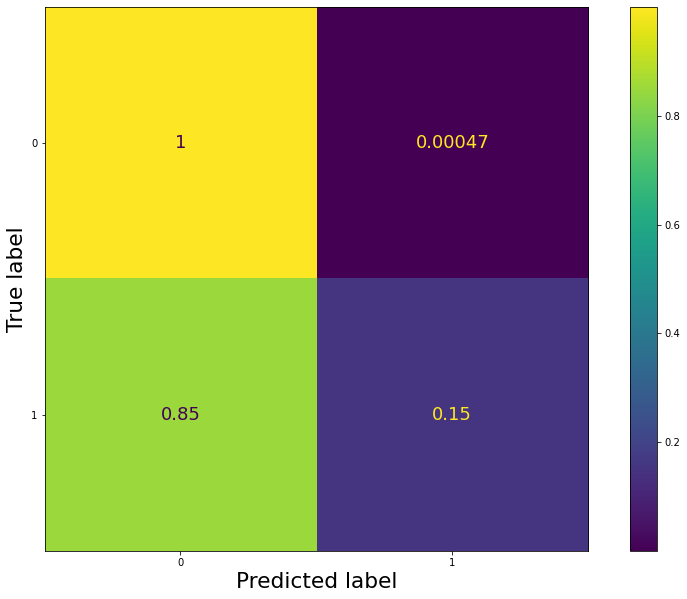

In [207]:
logReg_clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='')
logReg_clf.fit(x_train[features_all], y_train)

# Metrics
y_pred_logReg = logReg_clf.predict(x_test[features_all])
saveTextFile(metricsFolder + '\\LogisticRegression01.txt', metrics.classification_report(y_test, y_pred_logReg))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(logReg_clf, x_test, y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\LogisticRegression01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(logReg_clf, x_test, y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\LogisticRegression02.png')

# Extra training for Log Reg
feats_logReg = features_all.copy()
for item in ['inAbstract300_Species', 
             'inAbstract500_Species',  
             'inAbstract300_Location',
             'inAbstract500_Location', 
             'sqrt_Num_Tokens_Between', 
             'Preposition_Between', 
             'sqrt_max_TFISF_Species',
            'log_max_TFISF_Species', 
             'Sent_Start_Species',
             'sqrt_Num_Verbs_Between',
             'max_TFISF_Species',
             'log_Num_Verbs_Between',
             'sqrt_Num_Nouns_Between']:
    
    if item in feats_logReg:
        feats_logReg.remove(item)
    
logReg_mod_formula = "Tagged_Relationship ~ "

for feat in feats_logReg[:-1]:
    logReg_mod_formula = logReg_mod_formula + feat + ' + '
    
logReg_mod_formula = logReg_mod_formula + feats_logReg[-1]

pd.concat([x_train, y_train], axis=1)
    
logReg_mod = logit(logReg_mod_formula, pd.concat([x_train, y_train], axis=1)).fit()

# Summary
print(logReg_mod.summary())

y_pred_logReg2       = logReg_mod.predict(x_test)
y_pred_logReg2_round = np.round(y_pred_logReg2)

# New metrics
saveTextFile(metricsFolder + '\\LogisticRegression02.txt', metrics.classification_report(y_test, y_pred_logReg2_round))

combinedFeats = list(set(top_abst_features+ top_et_features+ top_lgbm_features+ top_rf_features))


### Neural Network

In [208]:
y_test_NN      = np.ravel(y_test)
y_train_NN     = np.ravel(y_train)
scaler         = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled  = scaler.transform(x_test)  
model          = Sequential()

model.add(Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[tf.keras.metrics.Recall()]
)

model.fit(x_train_scaled, y_train_NN, epochs=20, 
          batch_size=32, 
          verbose=1
         )

predict_x = model.predict(x_test_scaled) 
y_pred_NN = np.argmax(predict_x,axis=1)

# Save metrics
saveTextFile(metricsFolder + '\\NeuralNetwork.txt', metrics.classification_report(y_test, y_pred_NN))

Epoch 1/20
1247/1247 [==============================] - 1s 822us/step - loss: 0.0609 - recall_1: 0.0000e+00
Epoch 2/20
1247/1247 [==============================] - 1s 809us/step - loss: 0.0165 - recall_1: 0.0000e+00
Epoch 3/20
1247/1247 [==============================] - 1s 815us/step - loss: 0.0127 - recall_1: 0.0000e+00
Epoch 4/20
1247/1247 [==============================] - 1s 841us/step - loss: 0.0112 - recall_1: 0.0000e+001s
Epoch 5/20
1247/1247 [==============================] - 1s 826us/step - loss: 0.0104 - recall_1: 0.0000e+00
Epoch 6/20
1247/1247 [==============================] - 1s 810us/step - loss: 0.0097 - recall_1: 0.0000e+00
Epoch 7/20
1247/1247 [==============================] - 1s 833us/step - loss: 0.0092 - recall_1: 0.0000e+00
Epoch 8/20
1247/1247 [==============================] - 1s 836us/step - loss: 0.0087 - recall_1: 0.0000e+00
Epoch 9/20
1247/1247 [==============================] - 1s 811us/step - loss: 0.0084 - recall_1: 0.0000e+00
Epoch 10/20
1247/1247 [===

### kNN

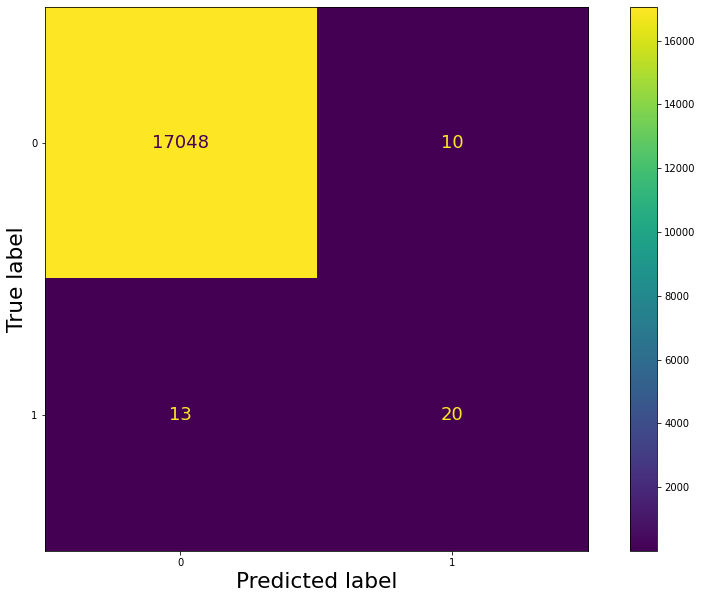

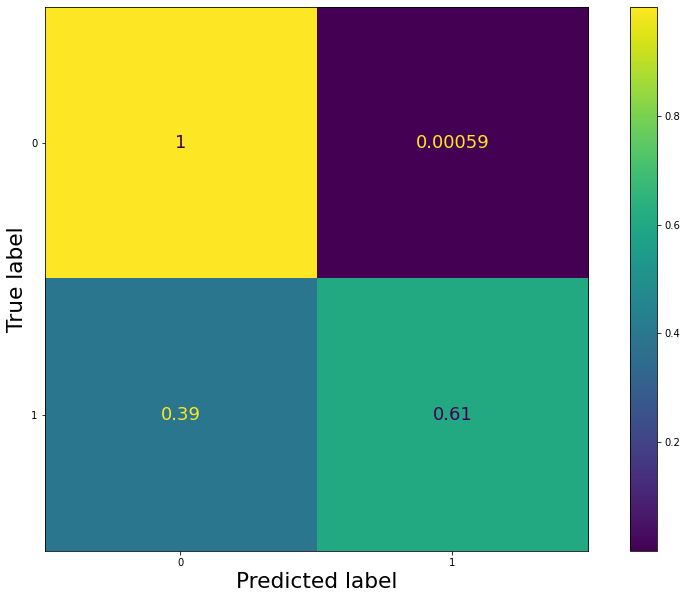

In [209]:
scaler         = StandardScaler().fit(x_train[features_raw])
x_train_scaled = scaler.transform(x_train[features_raw])
x_test_scaled  = scaler.transform(x_test[features_raw])  
knn_clf        = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(x_train_scaled, y_train)
y_pred_knn     = knn_clf.predict(x_test_scaled)

# Metrics
saveTextFile(metricsFolder + '\\kNN.txt', metrics.classification_report(y_test, y_pred_knn))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(knn_clf, x_test_scaled, y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\kNN01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(knn_clf, x_test_scaled, y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\kNN02.png')

## Downsampling

0    78
1    78
Name: Tagged_Relationship, dtype: int64
0    156
1     78
Name: Tagged_Relationship, dtype: int64
0    390
1     78
Name: Tagged_Relationship, dtype: int64
0    780
1     78
Name: Tagged_Relationship, dtype: int64
0    3900
1      78
Name: Tagged_Relationship, dtype: int64
0    7800
1      78
Name: Tagged_Relationship, dtype: int64


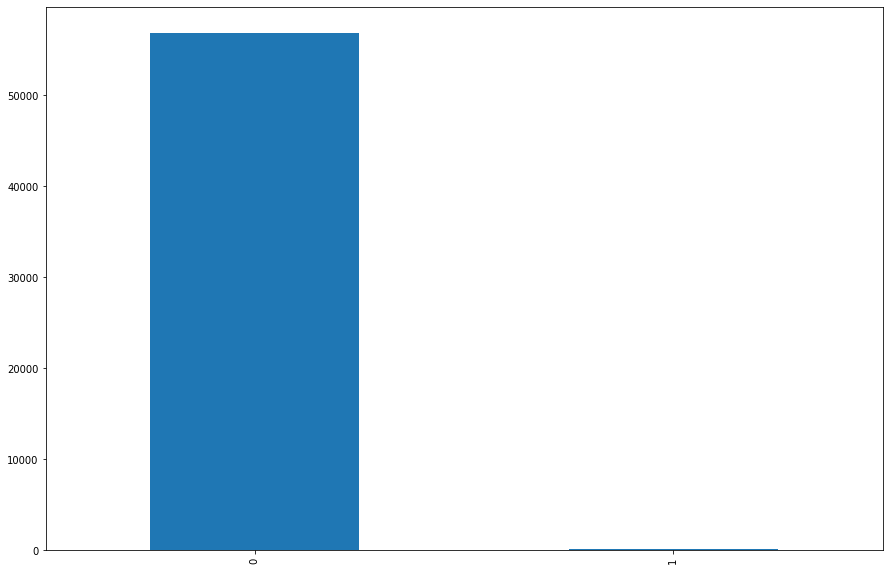

In [232]:
# Relationship ratios
string =  'Actual Relationships: '  + str(relations['Tagged_Relationship'].value_counts()[1]) 
string += '\nNot Relationships: '    + str(relations['Tagged_Relationship'].value_counts()[0])
string += '\nRatio of non to true: ' + str(int(relations['Tagged_Relationship'].value_counts()[0]/relations['Tagged_Relationship'].value_counts()[1]))
string += ':1'
saveTextFile(resultsFolder + '\\RelationshipToNonRelationship.txt', string)

relations['Tagged_Relationship'].value_counts().plot.bar()

# First Downsample
downsample1to1   = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 1)
downsample2to1   = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 2)
downsample5to1   = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 5)
downsample10to1  = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 10)
downsample50to1  = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 50, True)
downsample100to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 100, True)
downsamples      = [downsample100to1, downsample50to1, downsample10to1, downsample5to1, downsample2to1]
samplenames      = ['downsample100to1', 'downsample50to1', 'downsample10to1', 'downsample5to1', 'downsample2to1']

model     = []
sample    = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)
    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[features_raw], y_train)
y_pred_et = et_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Extra Trees - '+ name)

    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)
y_pred_rf = rf_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Random Forest - '+ name)
    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))
    
model     = []
sampling  = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM')
sampling.append('Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM')
    sampling.append(name)

    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees')
sampling.append('Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[features_raw], y_train)
y_pred_et = et_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Extra Trees')
    sampling.append(name)
    
    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[features_raw])


    
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest')
sampling.append('Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)
y_pred_rf = rf_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    
    model.append('Random Forest')
    sampling.append(name)

    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[features_raw])

    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))
    
# Out the First results
pd.DataFrame({'Model':model, 'Sample':sampling, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False).to_csv(resultsFolder + '\\DownSample01.csv')

# Second Down Sample
model     = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)

    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[top_lgbm_features])
    
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_et = et_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Extra Trees - '+ name)

    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)

    y_pred_ds_et_test = ds_et_clf.predict(x_test[top_lgbm_features])

    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_rf = rf_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Random Forest - '+ name)

    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)

    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[top_lgbm_features])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

# Out the second results
pd.DataFrame({'Model':model, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False).to_csv(resultsFolder + '\\DownSample02.csv')

# Top Features
top_tree_features = top_lgbm_features[:13]

# Third Downsample
model     = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[top_tree_features], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)
    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[top_tree_features])
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[top_tree_features], y_train)
y_pred_et = et_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Extra Trees - '+ name)
    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[top_tree_features])
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[top_tree_features], y_train)
y_pred_rf = rf_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']
    model.append('Random Forest - '+ name)
    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[top_tree_features])   
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

# Out the results
pd.DataFrame({'Model':model, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False).to_csv(resultsFolder + '\\DownSample03.csv')

## Cross Validation

In [238]:
scores = cross_val_score(lgbm_clf, X, y, cv=5, scoring='f1')

print ('Relationship stats')
for source in relations.Document.unique():
    print(source, '\n',relations[relations.Document==source].Tagged_Relationship.value_counts()[1], '/', len(relations[relations.Document==source]), '\t', 
          np.round(relations[relations.Document==source].Tagged_Relationship.value_counts(normalize = True)[1],4), '\n')
    
skf = StratifiedKFold(n_splits=5, shuffle=True)

Relationship stats
Archer2017_Article_EndolithicMicrobialDiversityIn.txt 
 24 / 18408 	 0.0013 

summer_activity_patterns_for_mosses_and_lichens_in_maritime_antarctica.txt 
 87 / 38562 	 0.0023 



In [239]:
cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'lgbm')

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.261905,0.234043,0.135135,0.213592,0.212963,0.211528
Recall,1.000000,1.000000,0.909091,1.000000,1.000000,0.981818
F1,0.415094,0.379310,0.235294,0.352000,0.351145,0.346569


In [240]:
cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'lgbm')

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.647059,0.558824,0.476190,0.468085,0.571429,0.544317
Recall,1.000000,0.863636,0.909091,1.000000,0.695652,0.893676
F1,0.785714,0.678571,0.625000,0.637681,0.627451,0.670884


In [241]:
lgbmfull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'lgbm')
lgbmfull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.400000,0.500000,0.342857,0.100000,0.444444,0.357460
Recall,0.545455,0.318182,0.545455,0.136364,0.521739,0.413439
F1,0.461538,0.388889,0.421053,0.115385,0.480000,0.373373


In [242]:
lgbmfull['Cross-Val Mean'][0]

0.3574603174603175

In [243]:
try:
    lgbm50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'lgbm')
except:
    lgbm50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'lgbm', True)
lgbm50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.550000,0.538462,0.431818,0.468085,0.484848,0.494643
Recall,1.000000,0.954545,0.863636,1.000000,0.695652,0.902767
F1,0.709677,0.688525,0.575758,0.637681,0.571429,0.636614


In [244]:
try:
    lgbm20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'lgbm')
except:
    lgbm20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'lgbm', True)
lgbm20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.309859,0.423077,0.276923,0.448980,0.310811,0.353930
Recall,1.000000,1.000000,0.818182,1.000000,1.000000,0.963636
F1,0.473118,0.594595,0.413793,0.619718,0.474227,0.515090


In [245]:
try:
    lgbm10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'lgbm')
except:
    lgbm10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'lgbm', True)
lgbm10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.258824,0.282051,0.229885,0.215686,0.283951,0.254079
Recall,1.000000,1.000000,0.909091,1.000000,1.000000,0.981818
F1,0.411215,0.440000,0.366972,0.354839,0.442308,0.403067


In [246]:
try:
    lgbm5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'lgbm')
except:
    lgbm5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'lgbm', True)
lgbm5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.261905,0.234043,0.135135,0.213592,0.212963,0.211528
Recall,1.000000,1.000000,0.909091,1.000000,1.000000,0.981818
F1,0.415094,0.379310,0.235294,0.352000,0.351145,0.346569


In [247]:
lgbm2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'lgbm')
lgbm2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.15942,0.136646,0.055416,0.091667,0.184000,0.12543
Recall,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000
F1,0.27500,0.240437,0.105012,0.167939,0.310811,0.21984


In [248]:
rffull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'RandomForest')
rffull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.850000,0.857143,0.681818,0.769231,0.875000,0.806638
Recall,0.772727,0.818182,0.681818,0.909091,0.608696,0.758103
F1,0.809524,0.837209,0.681818,0.833333,0.717949,0.775967


In [249]:
try:
    rf100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'RandomForest')
except:
    rf100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'RandomForest', True)
rf100

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.709677,0.617647,0.473684,0.488889,0.740741,0.606128
Recall,1.000000,0.954545,0.818182,1.000000,0.869565,0.928458
F1,0.830189,0.750000,0.600000,0.656716,0.800000,0.727381


In [250]:
try:
    rf50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'RandomForest')
except:
    rf50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'RandomForest', True)
rf50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.578947,0.466667,0.475000,0.415094,0.552632,0.497668
Recall,1.000000,0.954545,0.863636,1.000000,0.913043,0.946245
F1,0.733333,0.626866,0.612903,0.586667,0.688525,0.649659


In [251]:
try:
    rf20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'RandomForest')
except:
    rf20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'RandomForest', True)
rf20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.328358,0.392857,0.344262,0.328358,0.381818,0.355131
Recall,1.000000,1.000000,0.954545,1.000000,0.913043,0.973518
F1,0.494382,0.564103,0.506024,0.494382,0.538462,0.519470


In [252]:
try:
    rf10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'RandomForest')
except:
    rf10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'RandomForest', True)
rf10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.244444,0.297297,0.241379,0.220000,0.291667,0.258958
Recall,1.000000,1.000000,0.954545,1.000000,0.913043,0.973518
F1,0.392857,0.458333,0.385321,0.360656,0.442105,0.407855


In [253]:
rf5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'RandomForest')
rf5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.226804,0.194690,0.127273,0.166667,0.212121,0.185511
Recall,1.000000,1.000000,0.954545,1.000000,0.913043,0.973518
F1,0.369748,0.325926,0.224599,0.285714,0.344262,0.310050


In [254]:
rf2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'RandomForest')
rf2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.101382,0.080882,0.065282,0.103774,0.136364,0.097537
Recall,1.000000,1.000000,1.000000,1.000000,0.913043,0.982609
F1,0.184100,0.149660,0.122563,0.188034,0.237288,0.176329


In [255]:
etfull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'ExtraTrees')
etfull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.857143,0.833333,0.692308,0.807692,0.888889,0.815873
Recall,0.818182,0.909091,0.818182,0.954545,0.695652,0.839130
F1,0.837209,0.869565,0.750000,0.875000,0.780488,0.822452


In [256]:
try:
    et100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'ExtraTrees')
except:
    et100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'ExtraTrees', True)
et100

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.687500,0.617647,0.475000,0.550000,0.642857,0.594601
Recall,1.000000,0.954545,0.863636,1.000000,0.782609,0.920158
F1,0.814815,0.750000,0.612903,0.709677,0.705882,0.718656


In [257]:
try:
    et50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'ExtraTrees')
except:
    et50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'ExtraTrees', True)
et50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.536585,0.538462,0.413043,0.458333,0.525000,0.494285
Recall,1.000000,0.954545,0.863636,1.000000,0.913043,0.946245
F1,0.698413,0.688525,0.558824,0.628571,0.666667,0.648200


In [258]:
try:
    et20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'ExtraTrees')
except:
    et20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'ExtraTrees', True)
et20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.366667,0.458333,0.370370,0.338462,0.381818,0.383130
Recall,1.000000,1.000000,0.909091,1.000000,0.913043,0.964427
F1,0.536585,0.628571,0.526316,0.505747,0.538462,0.547136


In [259]:
try:
    et10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'ExtraTrees')
except:
    et10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'ExtraTrees', True)
et10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.252874,0.372881,0.235955,0.209524,0.269231,0.268093
Recall,1.000000,1.000000,0.954545,1.000000,0.913043,0.973518
F1,0.403670,0.543210,0.378378,0.346457,0.415842,0.417511


In [260]:
et5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'ExtraTrees')
et5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.213592,0.184874,0.146853,0.15942,0.207921,0.182532
Recall,1.000000,1.000000,0.954545,1.00000,0.913043,0.973518
F1,0.352000,0.312057,0.254545,0.27500,0.338710,0.306462


In [261]:
et2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'ExtraTrees')
et2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.141026,0.083650,0.100000,0.123596,0.159091,0.121472
Recall,1.000000,1.000000,1.000000,1.000000,0.913043,0.982609
F1,0.247191,0.154386,0.181818,0.220000,0.270968,0.214873


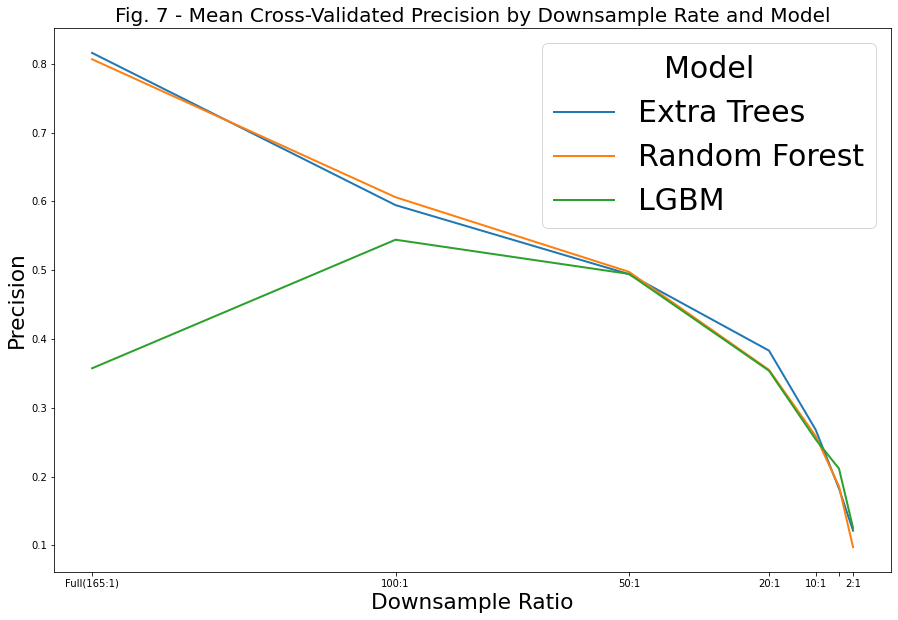

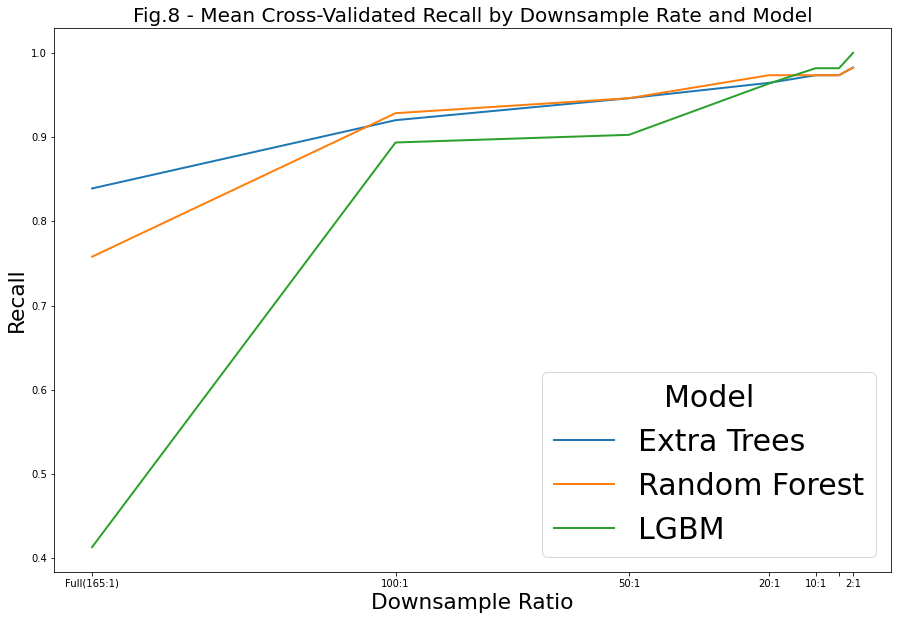

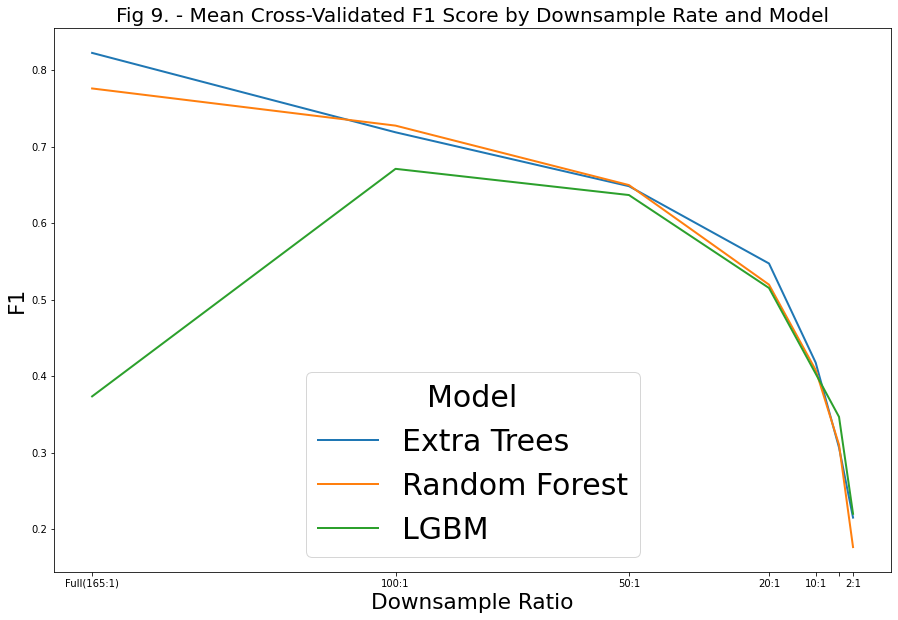

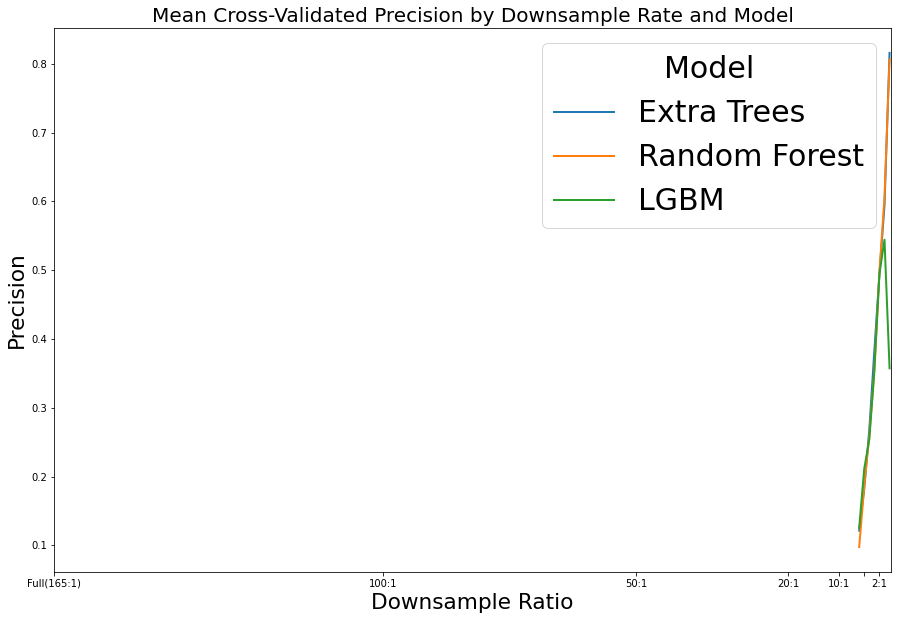

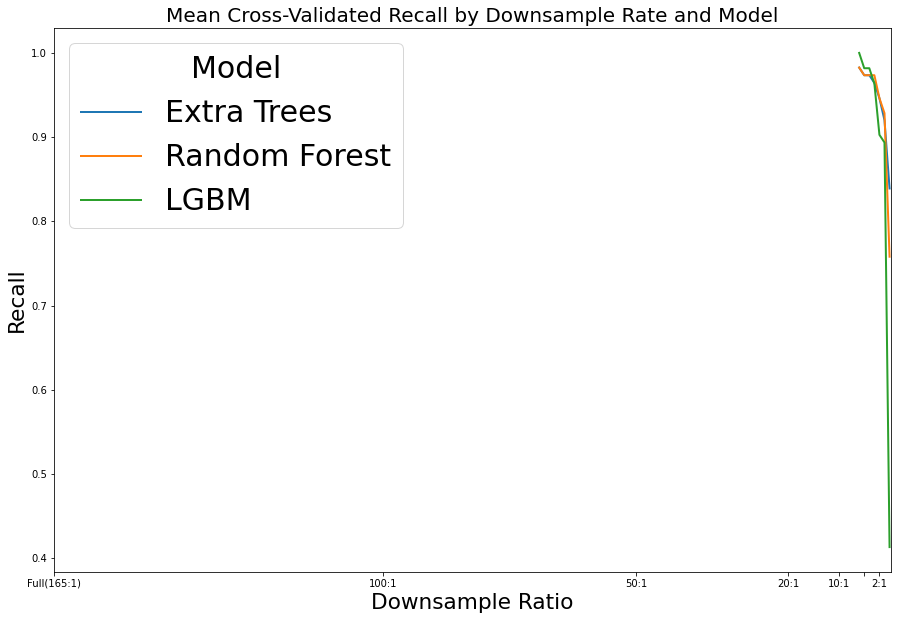

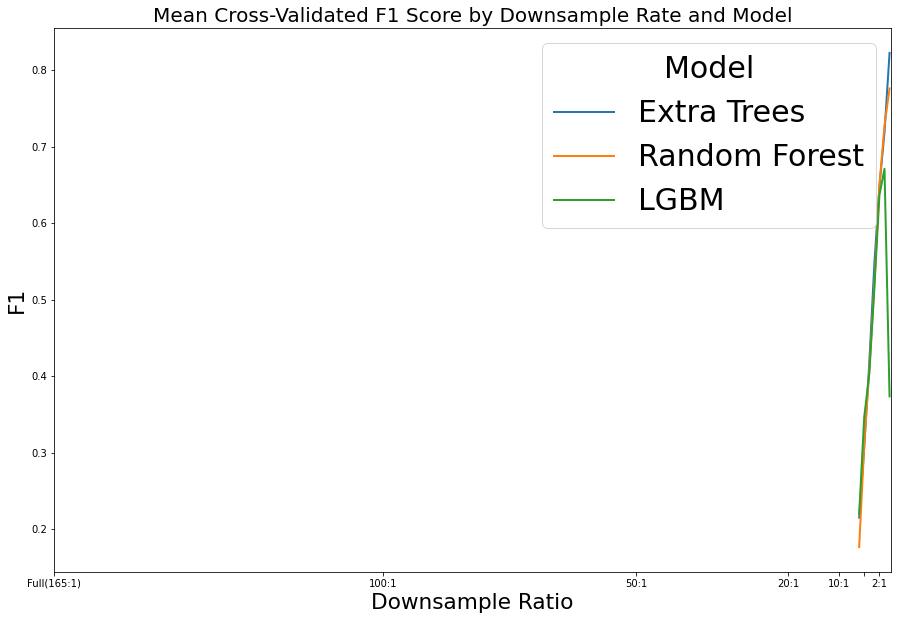

In [280]:
# Compound results to dataframe
modellist   = ['lgbm', 'RandomForest', 'ExtraTrees']
modelNames  = ['LGBM', 'Random Forest', 'Extra Trees']
downsamples =[100, 50, 20, 10, 5, 2]
model       = []
sampling    = []
Precision   = []
Recall      = []
F1          = []

for i, modeltype in enumerate(modellist):
    model.append(modelNames[i])
    sampling.append('Full Train Sample')
    try:
        results = cross_validation_no_downsample(relations,5,features_raw,'Tagged_Relationship', modeltype)
    except:
        results = cross_validation_no_downsample(relations,5,features_raw,'Tagged_Relationship', modeltype, True)
    F1.append(results['Cross-Val Mean'][2])
    Recall.append(results['Cross-Val Mean'][1])
    Precision.append(results['Cross-Val Mean'][0])
    
    for size in downsamples:
        model.append(modelNames[i])
        sampling.append('Downsample '+ str(size)+ ' to 1')
        try:
            results = cross_validation_with_downsample(relations,5,features_raw,'Tagged_Relationship', size, modeltype)
        except:
            results = cross_validation_with_downsample(relations,5,features_raw,'Tagged_Relationship', size, modeltype, True)
        F1.append(results['Cross-Val Mean'][2])
        Recall.append(results['Cross-Val Mean'][1])
        Precision.append(results['Cross-Val Mean'][0])

# First dataframe                    
crossValResults = pd.DataFrame({'Model':model, 'Sample':sampling, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False)
crossValResults.to_csv(resultsFolder + '\\CrossValidation01.csv')
crossValResults

# Second dataframe
ratio = {'Full Train Sample':165, 'Downsample 100 to 1':100, 'Downsample 50 to 1':50,
       'Downsample 20 to 1':20, 'Downsample 10 to 1':10, 'Downsample 5 to 1':5,
       'Downsample 2 to 1':2}
crossValResults['Sample Ratio'] = crossValResults['Sample'].map(ratio)
crossValResults.to_csv(resultsFolder + '\\CrossValidation02.csv')
crossValResults

# Mean Precision graph
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='Precision', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig. 7 - Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedPrecision.png')

# Mean cross validated recall
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig.8 - Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedRecall.png')

# Mean cross validated F1 
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig 9. - Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedF1.png')

# More tweaking of the Cross Validation Results
cols                  = list(crossValResults.columns[2:])
crossValResults[cols] = crossValResults[cols].apply(pd.to_numeric, errors='coerce', axis=1)
crossValResultsShort  = crossValResults.head(12)
crossValResults2      = crossValResults.tail(21).reset_index(drop=True)

crossValResults2.head(12).reset_index(drop=True, inplace=True)
crossValResultsShort.reset_index(drop=True, inplace=True)
crossValResults2.head(12) == crossValResultsShort

crossValResults       = crossValResults2

# Final results
crossValResults.to_csv(resultsFolder + '\\CrossValidationFinal.csv')
crossValResultsShort.to_csv(resultsFolder + '\\CrossValidationFinal-Short.csv')

# Not entirely sure what these graphs are for
crossValResults      = pd.read_csv(resultsFolder + '\\CrossValidationFinal.csv')
crossValResultsShort = pd.read_csv(resultsFolder + '\\CrossValidationFinal-Short.csv')

# Mean cross validated precision by downcample rate and model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Precision', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedPrecisionFinal.png')

# Mean cross validated recall by downsample rate and model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedRecallFinal.png')

# Mean cross validated F1 by downsample rate and model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedF1Final.png')

## Revised Plots for GIS Paper

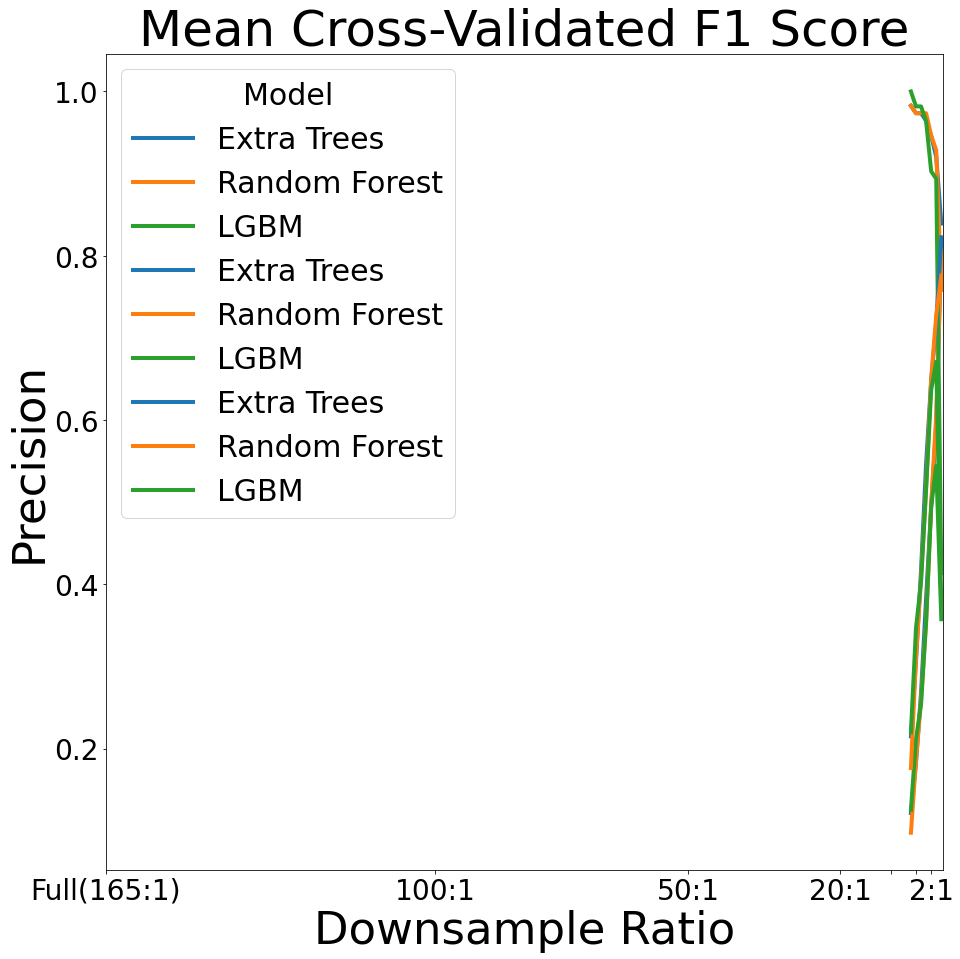

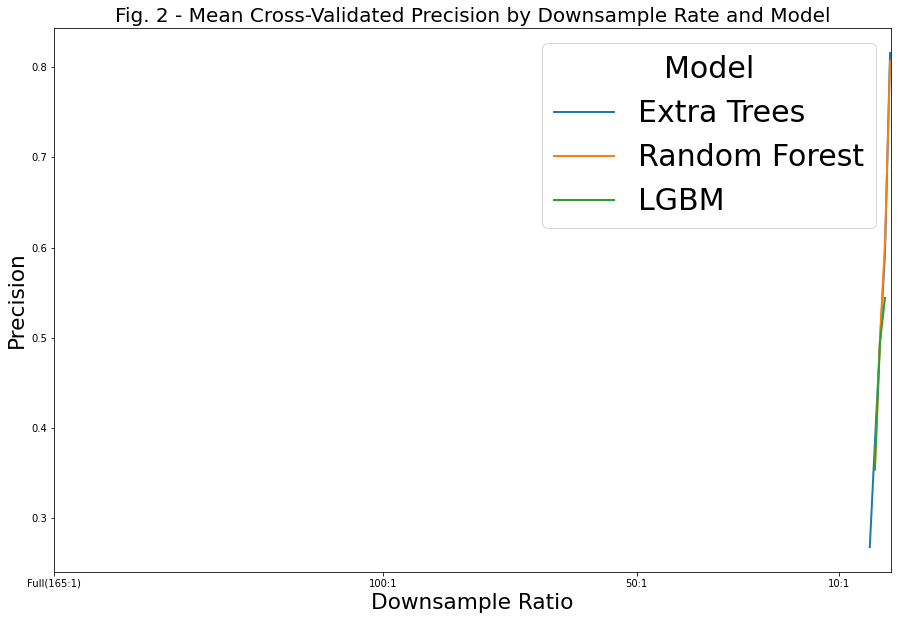

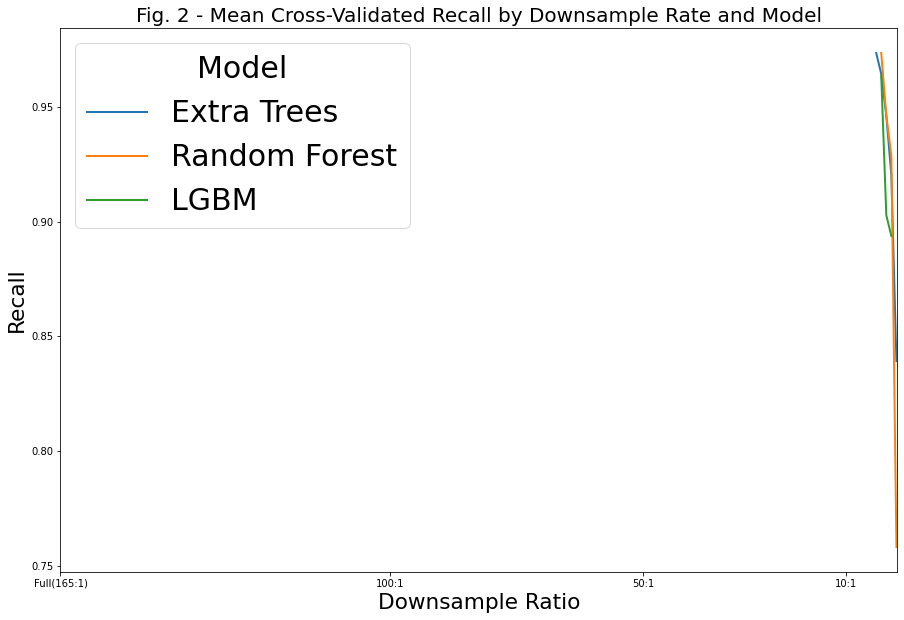

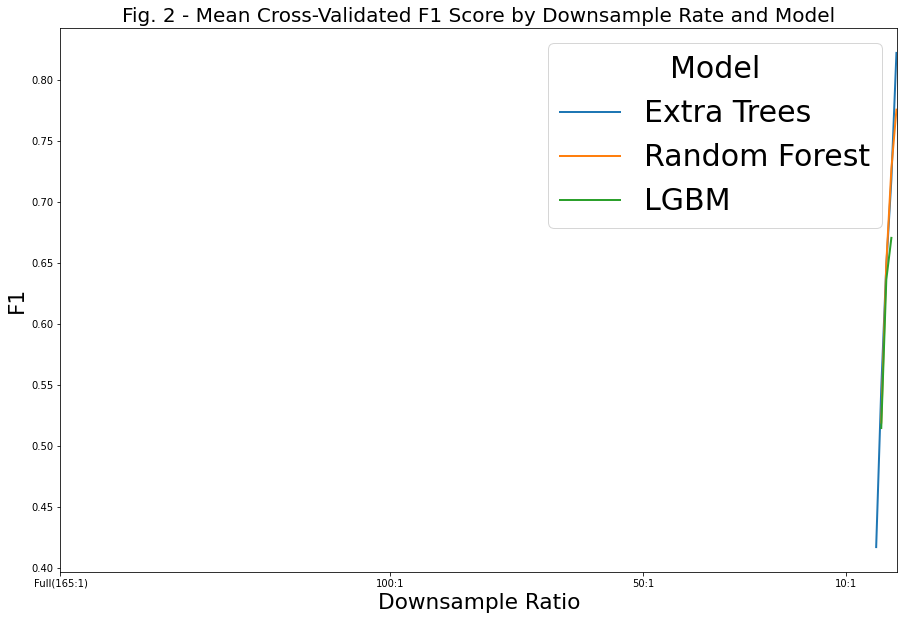

In [278]:
# Mean cross validated precision for GIS
rcParams['figure.figsize']        = 15, 15
rcParams['axes.titlesize']        = 50
rcParams['axes.labelsize']        = 45
rcParams['xtick.labelsize']       = 28
rcParams['ytick.labelsize']       = 28
rcParams['lines.linewidth']       = 4
rcParams['font.size']             = 18
rcParams['legend.fontsize']       = 30
rcParams['legend.title_fontsize'] = 30
ax                                = sns.lineplot(x    = 'Sample', 
                                                 y    = 'Precision', 
                                                 hue  = 'Model', 
                                                 data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Precision')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedPrecision.png')

# Mean cross validated Recall for GIS
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Recall')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedRecall.png')

# Mean cross validated F1 for GIS
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated F1 Score')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedF1.png')

# Precision by Downsample Rate and Model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Precision', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedPrecisionByDownsampleRateAndModel.png')

# Recall by Downsample Rate and Model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedRecallByDownsampleRateAndModel.png')

# F1 by Downsample Rate and Model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedF1ByDownsampleRateAndModel.png')

End.